In [1]:
# IMPORT PACKAGES

import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d


In [2]:
#===============================================================================================================================
# OPTIONS
#===============================================================================================================================

# directory
directory = "1D_models_1kl"
# initial model
initial_model = "NEW_oneit"

# calculate an average of the inverted models
calc_avg = True
calc_avg_smooth = True

avg_name = "NEW_avg_FINAL.vel"
sm_avg_name = "NEW_sm_avg.vel"

In [3]:
# DEFINE FILEPATHS

parent_dir = "/raid4/hra35"
models_path = os.path.join(parent_dir, directory)

input_model_path = os.path.join(models_path, "%s.vel" %initial_model)
esme_model_path = os.path.join(models_path, "esme_1k.vel")

random_models_path = os.path.join(models_path, "random_models") # directory containing the random models generated from input model  
inverted_models_path = os.path.join(models_path, "inverted_models") # directory containing models generated from inverting the random models
vgrids_path = os.path.join(models_path, "vgrids") # directory containing velociy grid files from the pseudo-1D inversions

picks_path = "/home/hra35/Documents/events/nll_script_outputs/D7_1D/picks_final.txt" # picks entering the 1D inversion

# list all grid files
p_grid_files = glob.glob(os.path.join(vgrids_path, "vgrids_p_*.in"))
p_grid_files = sorted(p_grid_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

s_grid_files = glob.glob(os.path.join(vgrids_path, "vgrids_s_*.in"))
s_grid_files = sorted(s_grid_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

print(len(p_grid_files))
print(len(s_grid_files))


100
100


In [4]:
# READ IN INITIAL MODEL AND ESME'S MODEL

initial_model_df = pd.read_csv(input_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")
esme_df = pd.read_csv(esme_model_path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")


In [5]:
# READ IN THE RANDOM STARTING MODELS USED FOR THIS RUN

random_model_files = glob.glob(os.path.join(random_models_path, "*.vel"))
random_model_files = sorted(random_model_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

random_model_dict = {}
for i in range(len(p_grid_files)):
    
    path = random_model_files[i]
    df = pd.read_csv(path, header = None, names = ["depth", "Vp", "Vs"], skiprows = 0, delimiter="\s+")
    random_model_dict[i] = df


In [6]:
# CALCULATE INVERTED MODELS FROM GRID FILES

# generate depth values
depths = np.arange(-1, 18, 1)

inverted_model_dict = {}
for i in range(len(p_grid_files)):
    
    p_grid = p_grid_files[i]
    s_grid = s_grid_files[i]
        
    # P model
    with open(p_grid, 'r') as file:
        lines = file.readlines()[4:]
        
    data = [float(line.strip().split()[0]) for line in lines if len(line.strip().split())!=0]
    data = [data[i:i+16] for i in range(0, len(data), 16)]
    df = pd.DataFrame(data)
    
    if df.empty == True:
        print(p_grid_files[i])
    
    # drop cushion node values
    df.drop([0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15], axis=1, inplace=True)
    df.drop([0, 20], axis=0, inplace=True)

    # calculate average velocity per depth
    p1d_model = df.mean(axis=1)
    p1d = p1d_model.iloc[::-1].reset_index(drop=True)
    p1d_model = pd.DataFrame({'Vp': p1d})

    # generate P-velocity model
    p1d_model.insert(0, 'depth', depths)
    
    # S model
    with open(s_grid, 'r') as file:
        lines = file.readlines()[4:]
        
    data = [float(line.strip().split()[0]) for line in lines if len(line.strip().split())!=0]
    data = [data[i:i+16] for i in range(0, len(data), 16)]
    df = pd.DataFrame(data)
    
    # drop cushion node values
    df.drop([0, 1, 2, 3, 4, 7, 8, 11, 12, 13, 14, 15], axis=1, inplace=True)
    df.drop([0, 20], axis=0, inplace=True)
    
    # calculate average velocity per depth
    s1d_model = df.mean(axis=1)
    s1d = s1d_model.iloc[::-1].reset_index(drop=True)
    s1d_model = pd.DataFrame({'Vs': s1d})
    
    # merge dataframes to generate the new model
    new_model = p1d_model
    new_model["Vs"] = s1d_model["Vs"]
    #print(new_model)

    inverted_model_dict[i] = new_model


In [7]:
# CALCULATE AN AVERAGE MODEL FROM ALL THE INVERTED MODELS

# empty dataframe to store the averaged model
average_model = pd.DataFrame(data=None, columns=["depth", "Vp", "Vs"])
smooth_average_model = pd.DataFrame(data=None, columns=["depth", "Vp", "Vs"])

# iterate through each depth
for dp in depths:
    dp_df = pd.DataFrame(data=None, columns=["Vp", "Vs"])
        
    for i in range(len(inverted_model_dict)):
        df = inverted_model_dict[i]
        vp = df.loc[df["depth"] == dp, "Vp"].values[0]
        vs = df.loc[df["depth"] == dp, "Vs"].values[0]
        data_row = {"Vp": vp, "Vs": vs}
        dp_df = dp_df.append(data_row, ignore_index=True)
    
    # take the average value for Vp and Vs at each depth
    Vp_average = dp_df['Vp'].mean()
    Vs_average = dp_df['Vs'].mean()
    data_row = {"depth": dp, "Vp": Vp_average, "Vs": Vs_average}
    
    # add to average model
    average_model = average_model.append(data_row, ignore_index=True)

# apply Gaussian filtering to smooth the average model

start_index = 6
end_index = 20
filtered_vp = gaussian_filter1d(average_model['Vp'][start_index:end_index], sigma=3)
filtered_vs = gaussian_filter1d(average_model['Vs'][start_index:end_index], sigma=2)
smoothed_model_vp = np.concatenate([average_model['Vp'][:start_index], filtered_vp, average_model['Vp'][end_index:]])
smoothed_model_vs = np.concatenate([average_model['Vs'][:start_index], filtered_vs, average_model['Vs'][end_index:]])
#smoothed_model_vs = gaussian_filter(average_model['Vs'], sigma=0.4)
    
smooth_average_model['depth'] = average_model['depth']
smooth_average_model['Vp'] = smoothed_model_vp
smooth_average_model['Vs'] = smoothed_model_vs


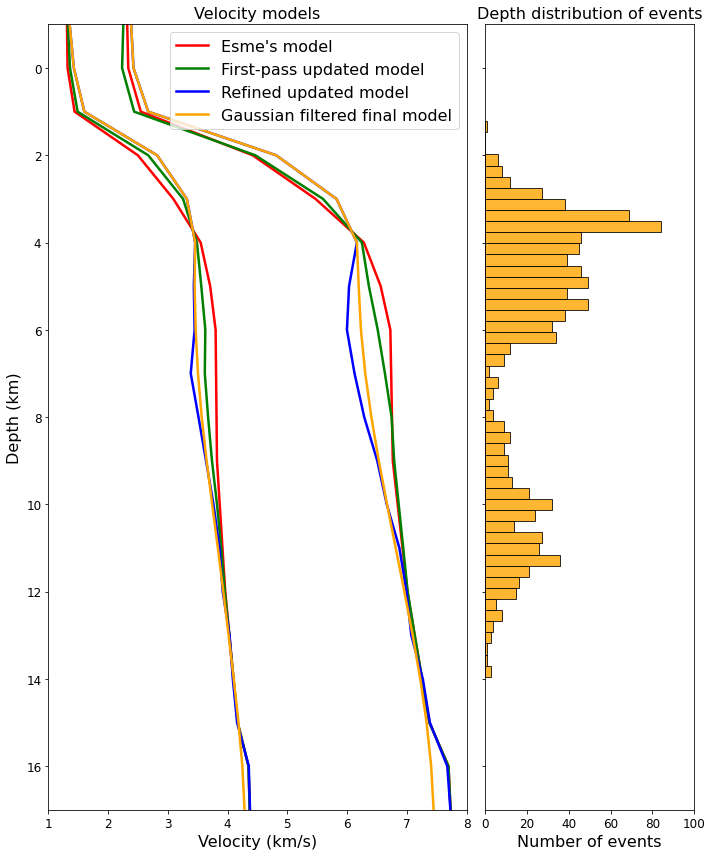

In [ ]:
# PLOT THE MODELS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

# VELOCITY MODELS

depth = random_model_dict[0]['depth']
#for i in range(len(p_grid_files)):
#    ax1.plot(random_model_dict[i]['Vp'], depth, marker='o',markersize=0.5, linewidth=0, linestyle='-', color="blue")
#    ax1.plot(random_model_dict[i]['Vs'], depth, marker='o',markersize=0.5, linewidth=0, linestyle='-', color="blue")
#    ax1.scatter(random_model_dict[i]['Vp'], depth, marker='o', s=2, color="gray")
#    ax1.scatter(random_model_dict[i]['Vs'], depth, marker='o', s=2, color="gray")

depth = inverted_model_dict[0]['depth']
#for i in range(len(p_grid_files)):
#    ax1.plot(inverted_model_dict[i]['Vp'], depth, marker='o',markersize=0.9, linewidth=0.5, linestyle='-', color="blue")
#    ax1.plot(inverted_model_dict[i]['Vs'], depth, marker='o',markersize=0.9, linewidth=0.5, linestyle='-', color="blue")

ax1.plot(esme_df['Vp'], esme_df['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, label="Esme's model", color='red')
ax1.plot(esme_df['Vs'], esme_df['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, color='red')

ax1.plot(initial_model_df['Vp'], initial_model_df['depth'], marker='o',markersize=0.1, linestyle='-', linewidth=2.5, label="First-pass updated model", color='green')
ax1.plot(initial_model_df['Vs'], initial_model_df['depth'], marker='o',markersize=0.1, linestyle='-', linewidth=2.5, color='green')

#ax1.plot(average_model['Vp'], average_model['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, label="Refined updated model", color='blue')
#ax1.plot(average_model['Vs'], average_model['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, color='blue')

ax1.plot(smooth_average_model['Vp'], smooth_average_model['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, label="Final model", color='orange')
ax1.plot(smooth_average_model['Vs'], smooth_average_model['depth'], marker='o',markersize=0.2, linestyle='-', linewidth=2.5, color='orange')

ax1.set_ylim(-1,17)
ax1.set_title('Velocity models', fontsize=16)
ax1.invert_yaxis()
ax1.set_xlim(1,8)
ax1.set_xlabel('Velocity (km/s)', fontsize=16)
ax1.set_ylabel('Depth (km)', fontsize=16)

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12) 

ax1.legend(fontsize=16)

# DEPTH DISTRIBUTION OF EVENTS

all_picks_df = pd.read_csv(picks_path, sep=r'\s+', skiprows=0, header=0)
all_picks_df.drop(["Weight", "NLL_res"], axis=1, inplace=True)
#print(len(all_picks_df))

grouped_df = all_picks_df.groupby("event_ID")
event_df = pd.DataFrame(data=None, columns=["event_ID", "depth"])

for group_name, group_data in grouped_df:
    
    evname = str(group_name)
    evdepth = group_data["depth"].iloc[0]
    data_row = {"event_ID": str(evname), "depth": float(evdepth)}
    
    event_df = event_df.append(data_row, ignore_index=True)

ax2.hist(event_df['depth'], bins=50, orientation='horizontal', color='orange', edgecolor='k', alpha=0.8, align='right')
ax2.set_xlabel('Number of events', fontsize=16)
ax2.set_title('Depth distribution of events', fontsize=16)
ax2.set_ylim(-1, 17)
ax2.set_xlim(0, 100)
ax2.tick_params(axis='x', labelsize=12)
ax2.invert_yaxis()

plt.tight_layout()

plt.savefig('1k_1Dmodel.png')

fig.show()

In [12]:
# SAVE AVERAGE MODEL AS FILE

if calc_avg == True:

    Vp = average_model["Vp"]
    Vs = average_model["Vs"]
    depth = average_model["depth"]

    # add top and bottom values to the model for FMTOMO
    top_row = {"depth": -10, "Vp": Vp[0], "Vs": Vs[0]}    
    bottom_row = {"depth": 20, "Vp": Vp[(len(Vp)-1)], "Vs": Vs[(len(Vs)-1)]}
    
    average_model = average_model.append(bottom_row, ignore_index=True)
    top_df = pd.DataFrame([top_row])
    final_df = top_df.append(average_model, ignore_index=True)
    average_model = final_df
    print(average_model)
    
    # save the random model into file
    average_model.to_csv(os.path.join(models_path, avg_name), index=False, header=False, sep="\t", float_format="%.6f")

    depth        Vp        Vs
0   -10.0  2.383567  1.354533
1   -10.0  2.383567  1.354533
2    -1.0  2.383567  1.354533
3     0.0  2.423533  1.425017
4     1.0  2.669949  1.600906
5     2.0  4.811987  2.818558
6     3.0  5.822067  3.316577
7     4.0  6.163266  3.455789
8     5.0  6.031792  3.433232
9     6.0  5.996352  3.446551
10    7.0  6.123488  3.381807
11    8.0  6.285995  3.511312
12    9.0  6.503755  3.637551
13   10.0  6.662952  3.762407
14   11.0  6.874337  3.863119
15   12.0  6.994536  3.917386
16   13.0  7.073382  4.031994
17   14.0  7.266145  4.086124
18   15.0  7.384269  4.157745
19   16.0  7.675842  4.353137
20   17.0  7.728309  4.373639
21   20.0  7.728309  4.373639
22   20.0  7.728309  4.373639


In [10]:
# SAVE SMOOTHED AVERAGE MODEL AS FILE

if calc_avg_smooth == True:

    Vp = smooth_average_model["Vp"]
    Vs = smooth_average_model["Vs"]
    depth = smooth_average_model["depth"]

    # add top and bottom values to the model for FMTOMO
    top_row = {"depth": -10, "Vp": Vp[0], "Vs": Vs[0]}    
    bottom_row = {"depth": 20, "Vp": Vp[(len(Vp)-1)], "Vs": Vs[(len(Vs)-1)]}
    
    smooth_average_model = smooth_average_model.append(bottom_row, ignore_index=True)
    top_df = pd.DataFrame([top_row])
    final_df = top_df.append(smooth_average_model, ignore_index=True)
    smooth_average_model = final_df
    print(smooth_average_model)
    
    # save the random model into file
    smooth_average_model.to_csv(os.path.join(models_path, sm_avg_name), index=False, header=False, sep="\t", float_format="%.6f")

    depth        Vp        Vs
0   -10.0  2.383567  1.354533
1    -1.0  2.383567  1.354533
2     0.0  2.423533  1.425017
3     1.0  2.669949  1.600906
4     2.0  4.811987  2.818558
5     3.0  5.822067  3.316577
6     4.0  6.163266  3.455789
7     5.0  6.192742  3.447145
8     6.0  6.230519  3.464330
9     7.0  6.303142  3.502803
10    8.0  6.405113  3.565191
11    9.0  6.529196  3.647654
12   10.0  6.667507  3.740855
13   11.0  6.812567  3.835565
14   12.0  6.957739  3.927152
15   13.0  7.096838  4.015508
16   14.0  7.223226  4.101233
17   15.0  7.329178  4.180995
18   16.0  7.406296  4.245443
19   17.0  7.447092  4.282129
20   20.0  7.447092  4.282129
